<a href="https://colab.research.google.com/github/TomYOON/Stock-project/blob/master/Basic_Model_v3_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# **Mount your drive**
본인의 구글 드라이브와 Colab을 연동합니다.

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#importing data from url

url="https://raw.githubusercontent.com/inuki81/stock-data/master/kospi200_10y_git.csv"
csv_df=pd.read_csv(url)

#  0     1    2    3     4      5    6    7
# year,month,day,close,volume,start,high,low

#date,close,start,high,low,volume

csv_np_raw = csv_df.to_numpy()
row,col = np.shape(csv_np_raw)

full_data_np = csv_np_raw[:,1:]





# **input data 변경**

In [0]:
#  0     1    2    3     4      5    6    7
# year,month,day,close,volume,start,high,low
###################################################
input_value = [1,0,2,3,4]
data_np = full_data_np[:,input_value]      #####여기있는 숫자 변경하면 input data 변경됨#####
##################################################

In [0]:
#normalize data

#data_min = np.min(data_np[:,1])
#data_scale = np.max(data_np[:,1]) - np.min(data_np[:,1])

scaler = MinMaxScaler()
scaler.fit(data_np)
data_norm = scaler.transform(data_np)
data_norm = np.insert(data_norm,0,np.arange(data_norm.shape[0]),axis=1)
#data = torch.from_numpy(data_norm)
#plt.plot(data_norm[:,0])

In [0]:
class MoreBasicLSTM(nn.Module):   
  def __init__(self, input_size, hidden, drop, output_size):
    super().__init__()
    self.date = output_size
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden)
    self.drop = nn.Dropout(p = drop)
    self.fclayers = nn.Sequential(
        nn.Softsign(),
        nn.Linear(in_features = hidden, out_features = output_size)
    )
    
    
  def forward(self, inputs):
    
    _,(hidden,_) = self.lstm(inputs)
    output = self.drop(hidden.squeeze(0))
    output = self.fclayers(output).squeeze(0)
    
    return output

In [0]:
class MoreBasicLSTM_timestamp_processing(nn.Module):   
  def __init__(self, input_size, hidden, drop, output_size):
    super().__init__()
    self.date = output_size
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden)
    self.drop = nn.Dropout(p = drop)
    self.fclayers = nn.Sequential(
        nn.Softsign(),
        nn.Linear(in_features = hidden, out_features = output_size)
    )
    
    
  def forward(self, inputs):
    input_without_timestamp = inputs[:,:,1:]
    batch_size = inputs
    
    _,(hidden,_) = self.lstm(input_without_timestamp)
    output = self.drop(hidden.squeeze(0))
    output = self.fclayers(output).squeeze(0)
    print(output.size())
    output = output.view(self.date,1)
    timestamps = torch.from_numpy(np.arange(self.date) + inputs[-1,:,0].item() + 1).view(self.date,1)
    
    return torch.cat([timestamps,output],axis=1)

In [0]:
class LSTM_twolayer(nn.Module):   
  def __init__(self, input_size, hidden, drop, output_size):
    super().__init__()
    self.date = output_size
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden, num_layers = 2, dropout = drop)
    self.drop = nn.Dropout(p = drop)
    self.fclayers = nn.Sequential(
        nn.Softsign(),
        nn.Linear(in_features = hidden, out_features = output_size)
    )
    
    
  def forward(self, inputs):
    
    _,(hidden,_) = self.lstm(inputs)
    output = self.drop(hidden[1,:,:].squeeze(0))
    output = self.fclayers(output).squeeze(0)
    
    return output

In [0]:
class LSTM_sequential(nn.Module):   
  def __init__(self, input_size, hidden, drop, num_layer=1):
    super().__init__()
    self.num_layers = num_layer
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden,num_layers = self.num_layers, dropout = drop)
    self.drop = nn.Dropout(p = drop)
    self.fclayers = nn.Sequential(
        nn.Softsign(),
        nn.Linear(in_features = hidden, out_features = 1)
    )
    
    
  def forward(self, inputs):
    
    _,(hidden,_) = self.lstm(inputs)
    output = self.drop(hidden[self.num_layers-1,:,:].squeeze(0))
    output = self.fclayers(output).squeeze(0)
    
    return output

#str 변환시 함수 이름이 출력되게함
  def __str__(self):
    return str(LSTM_sequential).split(".")[1][:-2]

In [0]:
def train(time_steps, date, data_target_batches, model, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0
  #prediction_list=[]
  batch_amount = len(data_target_batches)
  batch_size = list(data_target_batches[0][0].size())[1]
  model.train()
  
  for data, target in data_target_batches:
    
    assert target[0,0,0].item() == (data[-1,0,0].item() + 1)
    
    optimizer.zero_grad()   
    
    data_without_timestamp = data[:,:,1:].clone()

    all_predictions = []
    
    for d in range(date):
      prediction_batch = model(data_without_timestamp)
      all_predictions.append(prediction_batch)
      data_last = data_without_timestamp[-1:,:,:].clone()
      for b in range(batch_size):
        data_last[0,b,1] = prediction_batch[b].item()  


      data_without_timestamp = torch.cat((data_without_timestamp[1:,:,:],data_last),axis=0)

    target_without_timestamp = torch.squeeze(target[:,:,1])
    loss = criterion(torch.squeeze(target_without_timestamp), torch.squeeze(torch.cat(all_predictions,axis=1)))
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  
  return epoch_loss / batch_amount

In [0]:
def evaluate(time_steps, date, data, target, model, criterion):
  epoch_loss = 0
  epoch_acc = 0
  predictions=[]
  
  model.eval()
  num_tries = list(target.size())[1] - (date - 1)
  
  with torch.no_grad():
    for i in range(num_tries):

      starting_date = data[i:i+time_steps,:,:][-1,0,0].item()

      input_data = data[i:i+time_steps,:,1:]

      all_predictions = []

      for d in range(date):
        prediction = model(input_data)
        all_predictions.append(prediction)
        data_last = input_data[-1:,:,:].clone()
        data_last[0,0,1] = prediction.item()

        input_data = torch.cat((input_data[1:,:,:],data_last),axis=0)

      
      total_prediction = torch.tensor(all_predictions).to(device)
      
      timestamps = torch.from_numpy(np.arange(date) + starting_date + 1).to(device).view(date,1)
      
      prediction_with_time = torch.cat([timestamps,total_prediction.view(date,1)],axis=1)
      
      predictions.append(prediction_with_time.tolist())
      loss = criterion(torch.squeeze(target)[i:i+date,1],torch.squeeze(total_prediction))

      epoch_loss += loss.item()
    
  return epoch_loss/num_tries, np.array(predictions)

In [0]:
def view_plot(prediction_list, target_list):
  fig = plt.figure(figsize=(20, 20))

  ax = []
  for i in range(7):
    ax.append(fig.add_subplot(7,1,i+1)) 

  step = 100
  for i in range(1,8):
    start = (i-1) * step

    if i == 7: end = prediction_list.shape[0]
    else: end = i * step

  # try:
    ax[i-1].plot(target_list[0:,0][start:end],target_list[0:,1][start:end])
    ax[i-1].plot(prediction_list[:,0,0][start:end],prediction_list[:,0,1][start:end])
    for j in range(start, end):
      if j%foresee_date == 0:
        ax[i-1].plot(prediction_list[:,:,0][j],prediction_list[:,:,1][j], color = 'b')

In [0]:
def view_plot_val(prediction_list, target_list):
  fig = plt.figure(figsize=(20, 5))

  ax = []
  distribution = 2
  for i in range(distribution):
    ax.append(fig.add_subplot(distribution,1,i+1)) 

  step = 100
  for i in range(1,distribution+1):
    start = (i-1) * step

    if i == distribution: end = prediction_list.shape[0]
    else: end = i * step
  # try:
    ax[i-1].plot(target_list[0:,0][start:end],target_list[0:,1][start:end])
    ax[i-1].plot(prediction_list[:,0,0][start:end],prediction_list[:,0,1][start:end])
    for j in range(start, end):
      if j%foresee_date == 0:
        ax[i-1].plot(prediction_list[:,:,0][j],prediction_list[:,:,1][j], color = 'b')

**hyper parameter**


In [0]:
# lr = 0.0005
# time_steps = 20
# epoch = 50
# batch_size = 5
# dropout_rate = 0.3
# num_layers = 2
# input_size = data_np.shape[1] #open close high low volume
# #hidden1 = 100
# hidden = 25
# #fc = 15

# foresee_date = 5
# shuffle = True

# **create model**
지정 디렉터리에 같은 학습모델이 있을 경우, 그 모델을 불러와서 학습

1.   지정 디렉터리에 같은 학습모델이 있을 경우, 그 모델을 불러와서 학습
2.   마운트 필수



In [0]:
def call_model(model, num_layer, hidden_layer):

  path_dir = "/content/gdrive/My Drive/Colab Notebooks/stock_project/Models/"
  pretrained_model_list = os.listdir(path_dir)
  pretrained_model_list.sort()   #가장 loss가 낮은 모델을 부르기 위해 정렬 #저장양식 model_name + "-loss_"+str(int(loss*1000)) ex LSTM_sequential_loss_1 #모델/loss 구분 "-"(하이푼)
  i = 0
  model_state = model.state_dict()
  pre_train_loss = 1
  for trained_model in pretrained_model_list:
    i+=1
    if str(model) == trained_model.split("-")[0] and num_layer == int(trained_model.split("-")[1]) and hidden_layer == int(trained_model.split("-")[2]) and str(input_data)==trained_model.split("-")[3]:
      model_state = torch.load(path_dir+"/"+trained_model)["model_state"]
      #model.load_state_dict(torch.load(path_dir+"/"+trained_model)["model_state"])
      pre_train_loss = torch.load(path_dir+"/"+trained_model)["loss"]
      lr =torch.load(path_dir+"/"+trained_model)["lr"]
      optimzier = torch.load(path_dir+"/"+trained_model)["optimizer"]
      print("불러온 모델",trained_model, "pre_train_loss: ",pre_train_loss)   
      break
    if i == len(pretrained_model_list):
      print("저장된 같은 모델이 없습니다")
  return model_state, pre_train_loss




In [0]:
def data_preprocessing(data_norm,time_steps, foresee_date):
  slice_point = 800
  data_train_np = data_norm[:slice_point,:]
  data_val_np = data_norm[slice_point:,:]
  data_train_tensor = torch.from_numpy(np.expand_dims(data_train_np, axis=1)).to(device)
  data_val_tensor = torch.from_numpy(np.expand_dims(data_val_np, axis=1)).to(device)

  target_train_np = data_train_np[time_steps:,[0,2]]

  target_train_tensor = torch.from_numpy(np.expand_dims(target_train_np, axis=0)).to(device)
  target_val_np = data_val_np[time_steps:,[0,2]]
  target_val_tensor = torch.from_numpy(np.expand_dims(target_val_np, axis=0)).to(device)

  train_batches = []

  for i in range((slice_point - time_steps - (foresee_date - 1)) // batch_size):
    data_batch = []
    train_batch = []
    for b in range(batch_size):
      data_batch.append(data_train_tensor[i*batch_size + b:i*batch_size + b + time_steps,:,:])
      train_batch.append(target_train_tensor[:,i*batch_size + b:i*batch_size + b + foresee_date])
      
    train_batches.append((torch.cat(data_batch,axis=1),torch.cat(train_batch,axis=0)))

  return data_train_np, data_val_np, target_train_np, target_val_np, train_batches ,data_batch, data_val_tensor, data_train_tensor,target_train_tensor,target_val_tensor

**hyper parameter**


In [0]:
lr = 0.0005
time_steps = 20
epoch = 50
batch_size = 5
dropout_rate = 0.3
num_layers = 2
input_size = data_np.shape[1] #open close high low volume
#hidden1 = 100
hidden = 25
#fc = 15

foresee_date = 5
shuffle = True

# **Model training**
이전 모델의 loss보다 낮은 loss를 기록할 경우 자동 저장

In [0]:
save_point = 1       ##mamximum = 5040             ################여기서 포인트 설정#########################
count = 0 

In [68]:
dir = "/content/gdrive/My Drive/Colab Notebooks/stock_project/Models/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = data_np.shape[1]
pre_train_loss = 1

lr_list = [lr, lr/3, lr/5]
hidden_list = list(range(10,50,5))
num_layer_list = list(range(1,4))
foresee_date_list = list(range(1,6))
time_step_list = list(range(10,31))



# optimizer_list = [optim.Adam(model.parameters(), lr = lr), optim.SGD(model.parameters(), lr = lr)]

                     
try:
  for num_layer2 in num_layer_list:
    for h_layer2 in hidden_list:
      model = LSTM_sequential(input_size, hidden, dropout_rate, num_layer2)
      model = model.to(device)
      model = model.double()
      optimizer = optim.Adam(model.parameters(), lr = lr)
      criterion = nn.MSELoss()
      criterion = criterion.to(device)
      model_state, pre_train_loss =  call_model(model, num_layer2, h_layer2)
      model.load_state_dict(model_state)
      for time_step2 in time_step_list:
        for foresee_date2 in foresee_date_list:
          data_train_np, data_val_np, target_train_np, target_val_np, train_batches ,data_batch, data_val_tensor, data_train_tensor,target_train_tensor,target_val_tensor = data_preprocessing(data_norm, time_step2,foresee_date2)
          for lr2 in lr_list:
            count +=1
            #print(count)
            if count < save_point: continue         #저장지점까지 continue

            # if lr < lr2 and lr != lr_list[-1]:      #만약 불러온 모델의 lr이 더 낮을경우 그 lr에 대한 학습은 건너뜀, 제일 작은 lr경우는 학습함
            #   continue
            print("lr:",lr2, "foresee_date:",foresee_date2, "h_layer:",h_layer2, "num_layer:",num_layer2)
            if shuffle:
              random.shuffle(train_batches)
              for ep in range(100):
                optimizer = optim.Adam(model.parameters(), lr = lr2)
                start_time = time.time()
                train_loss = train(time_step2, foresee_date2, train_batches, model, optimizer, criterion)
                end_time = time.time()
                if ep%10 == 0:
                  print(train_loss)
                  print(end_time - start_time)
                  if train_loss < pre_train_loss and train_loss < 0.003:      #이전보다 loss가 낮으면 저장함.
                    pre_train_loss = train_loss           #제일 낮은 loss 갱신
                    if not os.path.exists(dir):
                      os.makedirs(dir)          #dir가 없으면 만들어서 저장
                    save_dict = {"model_state":model.state_dict(),
                                  "loss":train_loss,
                                  "lr": lr2,
                                  "optimizer": optimizer,
                                  "hidden_layer": h_layer2,
                                  "num_layers" : num_layer2,
                                  "time_step":time_step2,
                                  "foresee_date":foresee_date2,
                                  "criterion":criterion,
                                  "input_value":input_value}
                    model_name = dir+str(model)+"-"+str(num_layer2)+'-'+str(h_layer2)+"-"+str(input_value)+"-"+'loss_'+str(int(train_loss*1000))+".pt"         #여러명이 돌릴경우 직관성을 위해 filename에 loss도 포함
                    torch.save(save_dict,model_name)
                    print("save",model_name)
                    loss_train, predictions_train = evaluate(time_step2, foresee_date2, data_train_tensor, target_train_tensor, model, criterion)
                    view_plot(predictions_train, target_train_np)
                    loss_val, predictions_val = evaluate(time_step2,foresee_date2, data_val_tensor, target_val_tensor, model, criterion)
                    view_plot_val(predictions_val, target_val_np)
except Exception as inst:
  print(inst)
  print("your check point:", count)

  

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


불러온 모델 LSTM_sequential-1-10-[1, 0, 2, 3, 4]-loss_0.pt pre_train_loss:  0.0008315561496363087
lr: 0.0005 foresee_date: 1 h_layer: 10 num_layer: 1
0.0008864232278683559
0.44701528549194336


KeyboardInterrupt: ignored

In [0]:
def prediction(url, input_value, input_size):
  
  model = LSTM_sequential(input_size, hidden, dropout_rate, num_layer2)
  model = model.to(device)
  model = model.double() 
  
  path_dir = "/content/gdrive/My Drive/Colab Notebooks/stock_project/Models/"
  pretrained_model_list = os.listdir(path_dir)
  pretrained_model_list.sort()

  i=0

  for trained_model in pretrained_model_list:
    i+=1
    if str(input_data)==trained_model.split("-")[3]:
      state_dict = torch.load(path_dir+"/"+trained_model)
      model.load_state_dict(state_dict["model_state"])
      criterion = state_dict["criterion"]
      time_steps = state_dict["time_step"]
      forsee_date = state_dict["foresee_date"]
      input_value = state_dict["input_value"]
      break
    if i == len(pretrained_model_list):
      print("저장된 같은 모델이 없습니다")

  csv_df=pd.read_csv(url)
  csv_np_raw = csv_df.to_numpy()
  row,col = np.shape(csv_np_raw)

  full_data_np = csv_np_raw[:,1:]
  data_np = full_data_np[:,input_value]
  scaler = MinMaxScaler()
  scaler.fit(data_np)
  data_norm = scaler.transform(data_np)
  data_norm = np.insert(data_norm,0,np.arange(data_norm.shape[0]),axis=1)

  
  data_val_tensor = torch.from_numpy(np.expand_dims(data_norm, axis=1)).to(device)
  
  target_val_np = data_norm[time_steps:,[0,2]]
  target_val_tensor = torch.from_numpy(np.expand_dims(target_val_np, axis=0)).to(device)
  
  loss_val, predictions_val = evaluate(time_steps,foresee_date, data_val_tensor, target_val_tensor, model, criterion)
  
  view_plot(predictions_val, target_val_np)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


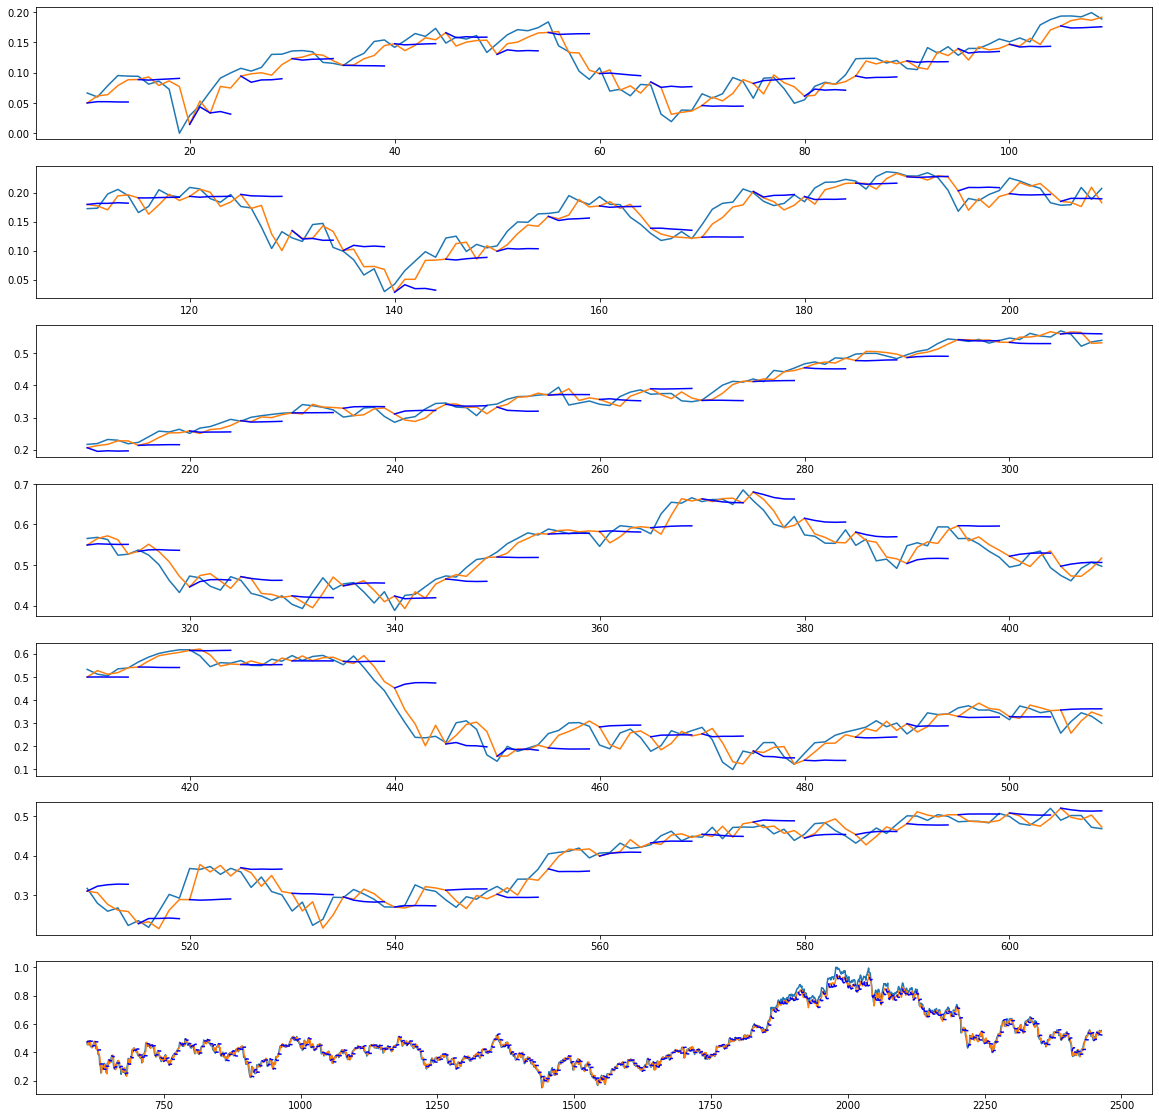

In [70]:
prediction(url, input_value,5)

In [0]:
#direc = "/content/gdrive/My Drive/Colab Notebooks/stock_project/Models/model1.py"
#torch.save(model.state_dict(), direc)

In [0]:
#model2 = LSTM_sequential(input_size, hidden, dropout_rate).to(device).double()
#model2.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/stock_project/Models/model1.py"))

In [0]:
loss_train, predictions_train = evaluate(time_steps, foresee_date, data_train_tensor, target_train_tensor, model, criterion)

# plt.plot(target_train_np[:,1])
# plt.plot(predictions_train[:,0,1])
view_plot(predictions_train, target_train_np)

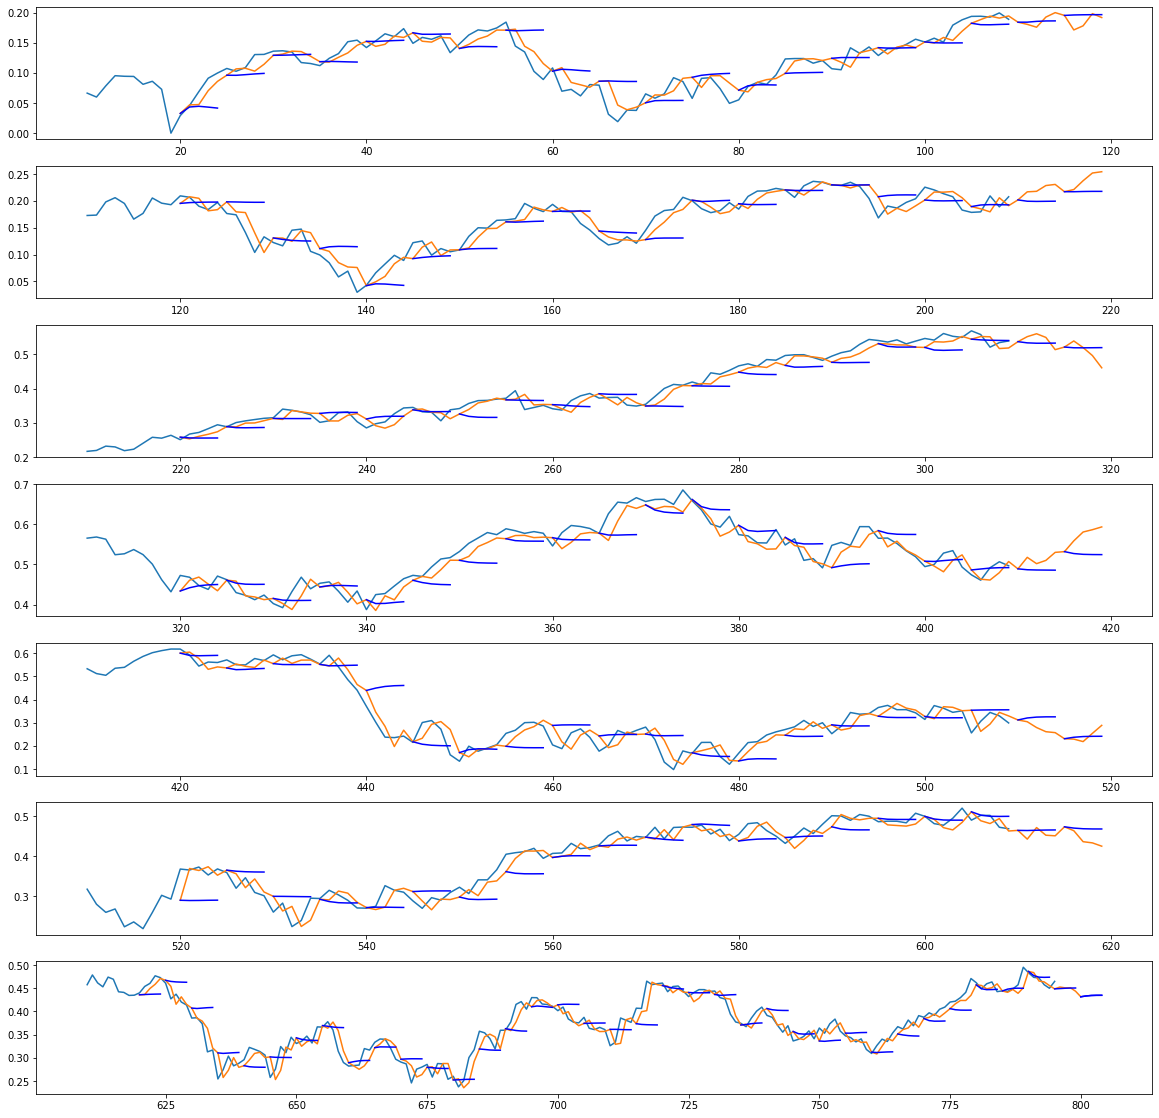

In [38]:
loss_train, predictions_train = evaluate(time_steps, foresee_date, data_train_tensor, target_train_tensor, model, criterion)

d = 1
#plt.figure(figsize=(100, 5))

view_plot(predictions_train, target_train_np)



In [0]:
#print(target_train_np[d - 1:,1])
#print(predictions_train[:,d-1,1])
#print(pre_with_time)
# print(predictions_train[:,:,1][:100])
# print(predictions_train[:,:,0][0])
#print(predictions_train[:2,:,1])
# print(predictions_train.shape[0])

In [0]:
loss_train, predictions_train = evaluate(time_steps,foresee_date, data_train_tensor, target_train_tensor, model, criterion)

d = 5
view_plot(predictions_train, target_train_np)
# plt.plot(target_train_np[d - 1:,1])
# plt.plot(predictions_train[:,d - 1,1])

In [0]:
loss_val, predictions_val = evaluate(time_steps,foresee_date, data_val_tensor, target_val_tensor, model, criterion)

d = 1

view_plot_val(predictions_val, target_val_np)
# plt.plot(target_val_np[d - 1:,1])
# plt.plot(predictions_val[:,d - 1,1])

In [0]:
predictions_val.shape

In [0]:
loss_val, predictions_val = evaluate(time_steps,foresee_date, data_val_tensor, target_val_tensor, model, criterion)

d = 5
view_plot_val(predictions_val, target_val_np)
# plt.plot(target_val_np[d - 1:,1])
# plt.plot(predictions_val[:,d - 1,1])

In [0]:
optimizer = optim.Adam(model.parameters(), lr = lr/3)

for ep in range(200):
  start_time = time.time()
  if shuffle:
    random.shuffle(train_batches)
  train_loss = train(time_steps,foresee_date, train_batches, model, optimizer, criterion)
  end_time = time.time()
  if ep%50 == 0:
    print(train_loss)



In [0]:
loss_train, predictions_train = evaluate(time_steps,foresee_date, data_train_tensor, target_train_tensor, model, criterion)

d = 1
view_plot(predictions_train, target_train_np)
# plt.plot(target_train_np[d - 1:,1])
# plt.plot(predictions_train[:,d - 1,1])

In [0]:
loss_train, predictions_train = evaluate(time_steps,foresee_date, data_train_tensor, target_train_tensor, model, criterion)

d = 5
view_plot(predictions_train, target_train_np)


In [0]:
loss_val, predictions_val = evaluate(time_steps,foresee_date, data_val_tensor, target_val_tensor, model, criterion)

d = 1
view_plot_val(predictions_val, target_val_np)
# plt.plot(target_val_np[d - 1:,1])
# plt.plot(predictions_val[:,d - 1,1])

In [0]:
loss_val, predictions_val = evaluate(time_steps,foresee_date, data_val_tensor, target_val_tensor, model, criterion)

d = 5
view_plot_val(predictions_val, target_val_np)
# plt.plot(target_val_np[d - 1:,1])
# plt.plot(predictions_val[:,d - 1,1])

In [0]:
optimizer = optim.Adam(model.parameters(), lr = lr/5)

for ep in range(200):
  start_time = time.time()
  train_loss = train(time_steps,foresee_date, train_batches, model, optimizer, criterion)
  end_time = time.time()
  if ep%50 == 0:
    print(train_loss)

In [0]:
loss_train, predictions_train = evaluate(time_steps,foresee_date, data_train_tensor, target_train_tensor, model, criterion)

d = 5

# print(predictions_train.shape)
# print(target_train_np.shape)

# plt.plot(target_train_np[d - 1:,1][300:500])
# plt.plot(predictions_train[:,d - 1,1][300:500])

# print(target_train_np[d - 1,0])
# print(predictions_train[0,d-1,0])
view_plot(predictions_train, target_train_np)


In [0]:
loss_val, predictions_val = evaluate(time_steps, foresee_date,data_val_tensor, target_val_tensor, model, criterion)

# d = 5

# plt.plot(target_val_np[d - 1:,1])
# plt.plot(predictions_val[:,d - 1,1])
view_plot_val(predictions_val, target_val_np)
